<a href="https://colab.research.google.com/github/lizhieffe/language_model/blob/main/Bert_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Good tutorial: https://coaxsoft.com/blog/building-bert-with-pytorch-from-scratch

Another tutorial: https://neptune.ai/blog/how-to-code-bert-using-pytorch-tutorial


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import re

from typing import Dict, List

import numpy as np

!pip install tqdm
from tqdm.auto import tqdm

In [2]:
USE_GPU = True

BLOCK_SIZE = 96 # Context length: how many chars do we take to predict the next one?

# number of workers in .map() call
# good number to use is ~order number of cpu cores // 2
NUM_PROC = 24

# The percentile of each single sentence' length in the overall dataset to be
# used as cutoff length of the sentence used in training examples.
OPTIMAL_LENGTH_PERCENTILE = 70

# Setup GPU

In [3]:
if USE_GPU:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  assert device.type != 'cpu', "GPU is not available"
else:
  device = 'cpu'

print(device)

cuda:0


In [4]:
g_cpu = torch.Generator(device='cpu').manual_seed(2147483647) # for reproducibility
g_device = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

# Tokenizer

- **TODO**: the tokenizer in IMDBBertDataset doesn't convert the word to id. It similar to splitting the sentence to words. Integrate with a more advanced one.

# Download Dataset

In [5]:
# Download data - openwebtext

!pip install datasets # Since we are running in colab docker image, install it here.

from datasets import load_dataset # huggingface datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.3 MB/s eta 0:00:00


In [6]:
# 50K imdb reviews.
# https://huggingface.co/datasets/imdb
dataset = load_dataset("imdb", num_proc=NUM_PROC)

Setting num_proc from 24 back to 1 for the train split to disable multiprocessing as it only contains one shard.


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Setting num_proc from 24 back to 1 for the test split to disable multiprocessing as it only contains one shard.


Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Setting num_proc from 24 back to 1 for the unsupervised split to disable multiprocessing as it only contains one shard.


Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [8]:
train_ds = dataset['train']

In [9]:
i = 0
for it  in train_ds:
  print(it)
  i += 1
  if i > 4:
    break

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [10]:
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

# Prepare DS

- The original BERT uses BooksCorpus (800M words) and English Wikipedia (2,500M words) for pre-training.
- We use IMDB reviews data with ~72k words.

In [11]:
class Counter():
  """Store the counts for individual tokens."""
  def __init__(self):
    self.token_to_counts = {}

  def update(self, tokens:  List[int]):
    """Update the counts with new tokens"""
    for t in tokens:
      if t in self.token_to_counts:
        self.token_to_counts[t] += 1
      else:
        self.token_to_counts[t] = 1

  def get(self) -> Dict[str, int]:
    return self.token_to_counts.copy()

  def __str__(self):
    s = sorted(self.token_to_counts.items(), key=lambda x:x[1], reverse=True)
    return s.__str__()

In [12]:
class Vocab:
  def __init__(self):
    self.ttoi = {}
    self.itot = {}

  def insert_token(self, t: str):
    assert t not in self.ttoi
    i = len(self.ttoi)
    self.ttoi[t] = i
    self.itot[i] = t

  def lookup_indices(self, tokens: List[str]):
    """Given a list of tokens in string, return the list of indices.

    Args:
      tokens: a list of tokens

    Return:
      a list of indices.
    """
    ret = []
    for t in tokens:
      if t in self.ttoi:
        ret.append(self.ttoi[t])
      else:
        ret.append(self.ttoi['[UNK]'])

    return ret

  def lookup_token(self, index: int):
    return self.itot[index]

In [13]:
# Define special tokens as attributes of class
CLS = '[CLS]'
PAD = '[PAD]'
SEP = '[SEP]'
MASK = '[MASK]'
UNK = '[UNK]'

In [14]:
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer('basic_english')

def build_vocab(ds: List[str], tokenizer) -> Vocab:
  sentences = []
  nsp = []

  counter = Counter()
  vocab = Vocab()

  def _fill_vocab(vocab, counter, min_freq=2):
    vocab.insert_token(CLS)
    vocab.insert_token(PAD)
    vocab.insert_token(MASK)
    vocab.insert_token(SEP)
    vocab.insert_token(UNK)

    token_to_counts = counter.get()
    for t, counts in tqdm(token_to_counts.items()):
      if counts >= min_freq:
        vocab.insert_token(t)

  # split ds on sentences
  for review in ds:
    review_sentences = review.split('. ')
    sentences += review_sentences

  # Create vocab
  print("Create vocabulary")
  for s in tqdm(sentences):
    counter.update(tokenizer(s))
  _fill_vocab(vocab, counter)
  print(f'\nvocab size = {len(vocab.ttoi)}')

  return vocab

vocab = build_vocab(dataset['train']['text'] + dataset['test']['text'], tokenizer)

Create vocabulary


  0%|          | 0/491161 [00:00<?, ?it/s]

  0%|          | 0/147156 [00:00<?, ?it/s]


vocab size = 71942


In [15]:
def find_optimal_sentence_length(ds: List[str], optimal_length_percentile: int) -> int:
  sentences = []
  nsp = []
  sentence_lens = []

  def _update_length(review_sentences: List[str],
                     sentence_lens: List[int]):
    for s in review_sentences:
      sentence_lens.append(len(s.split()))

  # split ds on sentences
  for review in ds:
    review_sentences = review.split('. ')
    sentences += review_sentences
    _update_length(review_sentences, sentence_lens)

  def _find_optimal_sentence_length(sentence_lens: List[int]):
    arr = np.array(sentence_lens)
    ret = int(np.percentile(arr, optimal_length_percentile))
    return ret

  optimal_sentence_length = _find_optimal_sentence_length(sentence_lens)

  return optimal_sentence_length

optimal_sentence_length = find_optimal_sentence_length(
    dataset['train']['text'] + dataset['test']['text'], OPTIMAL_LENGTH_PERCENTILE)
print(f'{optimal_sentence_length=}')

optimal_sentence_length=27


In [16]:
from torch.utils.data import Dataset
import pandas as pd
import random

class IMDBBertDataset(Dataset):
  """Dataset class.

  Bert has two tasks
  1) MLM (Mask LM)
  2) NSP (Next sentence prediction)

  Each example from this dataset contain info for both tasks.
  """

  MASK_PERCENTAGE = 0.15

  # ============================================================================
  # These are used as column keys in the generated examples (pandas.DataFrameformat)

  # The masked sentence's indices in its encoded form.
  MASKED_INDICES_COLUMN = 'masked_indices'
  # The unmasked sentence's indices in its encoded form.
  TARGET_COLUMN = 'indices'
  # The NSP task's label.
  NSP_TARGET_COLUMN = 'is_next'
  # The positions of the masked tokens (either [MASK], or replaced with a random
  # token), inversed. For masked token, the corresponding position's value is
  # False (that is why it is called inversed); otherwise True. Note that [CLS],
  # [PAD], [SEP], [UNK] are NOT considered as mask.
  INVERSE_TOKEN_MASK_COLUMN = 'inverse_token_mask'
  # ============================================================================



  def __init__(self,
               tokenizer,
               vocab: Vocab,
               ds_from: List[str],
               optimal_sentence_length: int,
               should_include_text: bool=False):
    """
    Args:
      should_include_text: if true, include the raw text in the dataset. This
        should only be used for debugging purpose.
    """
    super().__init__()

    # self.ds = ds_from
    self.ds = []
    # for it in dataset['train']:
    for it in ds_from:
      self.ds.append(it['text'])
      # self.ds.append(it)

    # self.tokenizer = get_tokenizer('basic_english')
    self.tokenizer = tokenizer
    # self.counter = Counter()
    self.vocab = vocab

    self.optimal_sentence_length = optimal_sentence_length
    # print(f'{self.optimal_sentence_length=}')
    self.should_include_text = should_include_text

    if self.should_include_text:
      self.columns = [
          'masked_sentence',
          self.MASKED_INDICES_COLUMN,
          'sentence',
          self.TARGET_COLUMN,
          self.INVERSE_TOKEN_MASK_COLUMN,
          self.NSP_TARGET_COLUMN,
      ]
    else:
      self.columns = [
          self.MASKED_INDICES_COLUMN,
          self.TARGET_COLUMN,
          self.INVERSE_TOKEN_MASK_COLUMN,
          self.NSP_TARGET_COLUMN,
      ]

    self.df = self._prepare_dataset()

  def __len__(self):
      return len(self.df)

  def __getitem__(self, idx: int)-> (torch.Tensor,
                                     torch.Tensor,
                                     torch.Tensor,
                                     torch.Tensor,
                                     torch.Tensor):
    """Implement self[idx] interface.

    Args:
      idx: the index of the example to get.

    Returns:
      inp: the encoded example. Note that for Bert the raw example is in form
        "[CLS] sen1 [SEP] sen2 [SEP]", where sen1 and sen2 are already masked
        and padded.
      attention_mask: True when input token is [PAD], otherwise False. It is
        used in the training process to extinguish the embeddings for [PAD]
        tokens to exclude [PAD] when calculating transfomer prediction.
      inverse_token_mask: see the comment for INVERSE_TOKEN_MASK_COLUMN.
      mlm_target: the MLM target. At the masked positions, it is the index of
        the expected token; at other positions, it is set to 0. Later in the
        model's loss, we use NLLLoss(ignore_index=0) to ignore the target which
        equal to 0 when calculating the loss. That's why we set the non-masked
        position's target to 0.
      nsp_target: the NSP target. It is a tensor of two items. It can be only in
        two states designating whether it is next sentence or not. If yes, it is
        [0, 1]; if not, it is [1, 0]. We use BCEWithLogitsLoss for training,
        which expect this format.
    """
    item = self.df.iloc[idx]

    inp = torch.Tensor(item[self.MASKED_INDICES_COLUMN]).long()

    attention_mask = (inp == self.vocab.lookup_indices([PAD])[0])

    inverse_token_mask = torch.Tensor(item[self.INVERSE_TOKEN_MASK_COLUMN]).bool()

    # MLM target.
    mlm_target = torch.Tensor(item[self.TARGET_COLUMN]).long()
    # Set the non-masked positions to be 0.
    mlm_target = mlm_target.masked_fill_(inverse_token_mask, 0)

    # NSP target
    if item[self.TARGET_COLUMN] == 0: # 2nd sen is not the next for 1st sen
      t = [1, 0]
    else:
      t = [0, 1]
    nsp_target = torch.Tensor(t)

    return (
        inp.to(device),
        attention_mask.to(device),
        inverse_token_mask.to(device),
        mlm_target.to(device),
        nsp_target.to(device)
    )

  def _create_item(self,
                   first: List[str],
                   second: List[str],
                   target: int) -> (List[str], List[int], List[str], List[int], List[bool], int):
    """Create an example.

    Args:
      first: the first sentence
      second: the second sentence
      target: the NSP label. E.g. if the second is the next sentence of first, true; otherwise, false.

    Returns:
      nsp_sentence: the example in str format. It is the contatenation of the two input sentences, with masking and padding.
      nsp_indices: indices of nsp_sentence.
      original_nsp_sentence: nsp_sentence without masking and padding.
      original_nsp_indices: indices of original_nsp_sentence.
      inverse_token_mask: indicates the corresponding indices are NOT masked. If
        the corresponding token is masked, False; otherwise, True. Also see
        comment for INVERSE_TOKEN_MASK_COLUMN.
      target: the same as target in Args.
    """
    # Create masked and padded sentence item
    first_updated, first_inverse_token_mask = self._preprocess_sentence(first.copy(), should_mask=True)
    second_updated, second_inverse_token_mask = self._preprocess_sentence(second.copy(), should_mask=True)

    # BERT was pretrained using the format [CLS] sen A [SEP] sen B [SEP].
    nsp_sentence = [CLS] + first_updated + [SEP] + second_updated + [SEP]
    nsp_indices = self.vocab.lookup_indices(nsp_sentence)
    inverse_token_mask = [True] + first_inverse_token_mask + [True] + second_inverse_token_mask + [True]

    # Create padded only item without masking
    first, _ = self._preprocess_sentence(first.copy(), should_mask=False)
    second, _ = self._preprocess_sentence(second.copy(), should_mask=False)

    original_nsp_sentence = [CLS] + first + [SEP] + second + [SEP]
    original_nsp_indices = self.vocab.lookup_indices(original_nsp_sentence)

    if self.should_include_text:
      return (
          nsp_sentence,
          nsp_indices,
          original_nsp_sentence,
          original_nsp_indices,
          inverse_token_mask,
          target
      )
    else:
      return (
          nsp_indices,
          original_nsp_indices,
          inverse_token_mask,
          target
      )

  def _select_false_nsp_sentences(self, sentences: List[str]):
    sentences_len = len(sentences)
    i1 = random.randint(0, sentences_len-1)
    i2 = random.randint(0, sentences_len-1)

    # Make sure they are really not NSP
    while i1 == i2 - 1:
      i2 = random.randint(0, sentences_len-1)

    return sentences[i1], sentences[i2]

  def _preprocess_sentence(self,
                           sentence: List[str],
                           should_mask: bool=True) -> (List[str], List[bool]):
    """Preprocess the sentence.

    1. Mask
    2. Pad

    Args:
      sentence: the sentence to preprocess
      should_mask: whether to mask the sentence

    Returns:
      sentence: the masked sentence.
      inverse_token_mask: a list of boolean, which indicates the corresponding
        indices are NOT masked. If the corresponding token is masked, false;
        otherwise, true. Also see comment for INVERSE_TOKEN_MASK_COLUMN.
    """
    inverse_token_mask = None
    if should_mask:
      sentence, inverse_token_mask = self._mask_sentence(sentence)

    sentence, inverse_token_mask = self._pad_sentence(sentence, inverse_token_mask)

    return sentence, inverse_token_mask

  def _mask_sentence(self, sentence: List[str]) -> (List[str], List[bool]):
    """Mask the sentence.

    Choose self.MASK_PERCENTAGE tokens randomly to do the mask. Of the masks,
    80% are updated to [MASK], 20% are updated to a random token in the vocab.

    Args:
      sentence: the sentence to mask

    Returns:
      sentence: the masked sentence.
      inverse_token_mask: a list of boolean, which indicates the corresponding
        indices are NOT masked. If the corresponding token is masked, false;
        otherwise, true. Also see comment for INVERSE_TOKEN_MASK_COLUMN.
    """
    len_s = len(sentence)

    # Mask random 15% tokens in the sentence.
    mask_amount = round(len_s * self.MASK_PERCENTAGE)
    mask_index = random.sample(range(0, len_s), mask_amount)

    # False at the index where the token is masked
    inverse_token_mask = [True for i in range(len_s)]

    assert mask_amount == len(mask_index)
    assert len_s == len(inverse_token_mask)

    # For the tokens to be masked, 80% update them to [MASK], 20% update to
    # random tokens.
    for ix in mask_index:
      if random.uniform(0, 1) < 0.8:
        sentence[ix] = MASK
      else:
        # for 20% avoid update to the special tokens.
        token_i = random.randrange(5, len(self.vocab.itot))
        sentence[ix] = self.vocab.lookup_token(token_i)

      inverse_token_mask[ix] = False

    return sentence, inverse_token_mask

  def _pad_sentence(self,
                    sentence: List[str],
                    inverse_token_mask: List[bool]=None) -> (List[str], List[bool]):
    len_s = len(sentence)

    assert self.optimal_sentence_length != None

    if len_s > self.optimal_sentence_length:
      sentence = sentence[:self.optimal_sentence_length]
    else:
      sentence = sentence + [PAD] * (self.optimal_sentence_length - len_s)

    if inverse_token_mask != None:
      assert len_s == len(inverse_token_mask), f"sentence {len_s} and inverse_token_mask {len(inverse_token_mask)} should have the same length"

      if len_s > self.optimal_sentence_length:
        inverse_token_mask = inverse_token_mask[:self.optimal_sentence_length]
      else:
        # [PAD] is not considered as masked, so set to True here.
        inverse_token_mask = inverse_token_mask + [True] * (self.optimal_sentence_length - len_s)

    return sentence, inverse_token_mask

  def _prepare_dataset(self) -> pd.DataFrame:
    """Generate the dataset.

    Return:
      The generated dataset.
    """
    sentences = []
    nsp = []

    # split ds on sentences
    for review in self.ds:
      review_sentences = review.split('. ')
      sentences += review_sentences

    iiii = 0
    print('Building examples...')
    for i in tqdm(range(len(self.ds))):
      review = self.ds[i]
    # for review in self.ds:
      review_sentences = review.split('. ')
      # For each review with >1 sentence we create true NSP examples (when the
      # 2nd sentence is the next sentence in review) and false NSP examples (
      # when the 2nd sentence is any random sentence that is not the next
      # sentence in review)
      if len(review_sentences) > 1:
        for i in range(len(review_sentences) - 1):
          # True NSP item
          first, second = self.tokenizer(review_sentences[i]), self.tokenizer(review_sentences[i+1])
          # print(f'{first=}, {second=}')
          nsp.append(self._create_item(first, second, target=1))

          # False NSP item
          first, second = self._select_false_nsp_sentences(sentences)
          first, second = self.tokenizer(first), self.tokenizer(second)
          # print(f'{first=}, {second=}')
          nsp.append(self._create_item(first, second, target=0))

    df = pd.DataFrame(nsp, columns=self.columns)
    return df

ds_train = IMDBBertDataset(tokenizer,
                           vocab,
                           ds_from=dataset['train'],
                           optimal_sentence_length=optimal_sentence_length,
                           should_include_text=False)

Building examples...


  0%|          | 0/25000 [00:00<?, ?it/s]

In [17]:
ds_dev = IMDBBertDataset(tokenizer,
                         vocab,
                         ds_from=dataset['test'],
                         optimal_sentence_length=optimal_sentence_length,
                         should_include_text=False)

Building examples...


  0%|          | 0/25000 [00:00<?, ?it/s]

In [18]:
# BERT was pretrained using the format [CLS] sen A [SEP] sen B [SEP].assert len(ds.df.iloc[0,:]['masked_indices']) == 3 + 2 * ds.optimal_sentence_length

In [19]:
ds=None

In [20]:
type(dataset['test']['text'])

list

In [21]:
ds_train.df.iloc[0,:]['inverse_token_mask']

[True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [22]:
ds_train.df.iloc[0,:]['is_next']

1

# Model

In [23]:
class JointEmbedding(torch.nn.Module):
  """Embedding layers for tokens.

  Bert uses a combination of three different embeddings:

  1. Token embedding
  2. Segment embedding
  3. Pos embedding

  """
  def __init__(self, vocab_size: int, embedding_dim: int):
    super().__init__()

    self.token_emb = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
    self.seg_emb = torch.nn.Embedding(num_embeddings=2, embedding_dim=embedding_dim)
    # Here we don't fix the length of the sen to be handled, so we give
    # `num_embeddings=1000` a relatively large number so that it can handle up
    # to 1000 length sentence. If the sentence length is fixed, num_embeddings
    # should be the fixed sentence length.
    self.pos_emb = torch.nn.Embedding(num_embeddings=1000, embedding_dim=embedding_dim)

    # TODO: use the norm
    self.norm = torch.nn.LayerNorm(embedding_dim)

  def forward(self, x):
    sentence_len = x.shape[-1]

    # 1st half of sen is 0, 2nd half is 1
    seg_tensor = torch.zeros_like(x).to(device)
    seg_tensor[:, sentence_len // 2+1:] = 1
    # print(f'{seg_tensor=}')

    # TODO: use periodic functions to encode positions. See https://coaxsoft.com/blog/building-bert-with-pytorch-from-scratch
    pos_tensor = torch.arange(sentence_len).to(device)
    # print(f'{pos_tensor=}')

    combined = self.token_emb(x) + self.seg_emb(seg_tensor) + self.pos_emb(pos_tensor)

    return combined

In [24]:
class LayerNorm(torch.nn.Module):
  """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

  def __init__(self, ndim: int, bias: bool):
    super().__init__()
    self.weight = torch.nn.Parameter(torch.ones(ndim)).to(device)
    self.bias = torch.nn.Parameter(torch.zeros(ndim)).to(device) if bias else None

  def forward(self, x):
    return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

In [25]:
class AttentionHead(torch.nn.Module):
  def __init__(self, d_in: int, d_head: int, d_hidden: int):
    """One single Attention head.

    Args:
      d_in: input dim
      d_head: output dim (how many heads)
      d_hidden: dim of the hidden FFN
    """

    super().__init__()

    self.d_head = d_head

    self.query = torch.nn.Linear(d_in, d_head, bias=False)
    self.key = torch.nn.Linear(d_in, d_head, bias=False)
    self.value = torch.nn.Linear(d_in, d_head, bias=False)

  def forward(self, x: torch.Tensor, attention_mask: torch.Tensor):
    """
    Args:
      attention_mask: True at the [PAD] positions. (B, T)
    """

    # x: (B, T, d_in)

    T = x.shape[-2]

    q = self.query(x) # (B, T, d_head)
    k = self.key(x)   # (B, T, d_head)
    v = self.value(x) # (B, T, d_head)

    # Here it doesn't matter if (k @ q^T) or (q @ k^T)
    #
    # Let's ignore B dim, then
    #
    # (k @ q^T) = (q @ k^T)^T
    #
    # Although (k @ q^T) equals the transpose of (q @ k^T), becuase query matrix
    # and key matrix are learned, they will just learn to adapt to its setup.
    score = k @ q.transpose(-2, -1)   # (B, T, T)
    # print(f'{score.shape=}')
    score = score * self.d_head**-0.5 # (B, T, T)

    # attention_mask is (B, T), and unsqueezed to (B, 1, T), score is (B, T, T).
    # When applying masked_fill_(), attention_mask is broadcasted to (B, T, T)
    #
    # Let's ignore B dim, and say
    #
    #         a11 a12
    # score = a21 a22
    #
    # Because the -2 dim is broadcast, score can be written
    #
    #         a1 a2
    # score = a1 a2
    #
    # Say
    #
    #      b11 b12 b13
    # v =  b21 b22 b23
    #
    # Then
    #
    #             a1*b11+a2*b21 a1*b12+a2*b22 a1*b13+a2*b23
    # score @ v = a1*b11+a2*b21 a1*b12+a2*b22 a1*b13+a2*b23
    #
    # Lets say T=0 is [PAD] masked, which means a1 == 0, then
    #
    #             a2*b21 b2*b22 b2*b23
    # score @ v = a2*b21 b2*b22 b2*b23
    #
    # It can be seen that b11, b12, b13 has no contribution. We know that
    # b1* is the v (value) for T=0, this means the [PAD]'s embedding has no
    # contribution. This proves the effect of attention_mask, is to make the
    # corresponding [PAD] has no effect to the result.

    attention_mask = attention_mask.unsqueeze(1) # (B, T) unsqueeze ----> (B, 1, T)
    score = score.masked_fill(attention_mask, 1e-9)

    # print(f'{score.shape=}')
    # print(f'{score=}')

    score = F.softmax(score, dim=-1)  # (B, T, T)

    y = score @ v # (B, T, d_head)

    return y

In [26]:
# TODO: what is the multi-head impl in Causal style?
class MultiHeadAttentionBlock(torch.nn.Module):
  def __init__(self, n_heads: int, d_in: int, d_head: int, d_hidden: int, dropout: float):
    """Impl of Multi Head Attention block.

    Note: based on [1], the input and output dim of Bert Attention block
      are the same. d_in is the input dim, it can be split into n_heads, each
      head has dim d_head. Based on [2], n_head's outputs are concatenated. This
      means the n_heads * d_head == d_in == [dim of Bert Attn block output].
      [1] https://stackoverflow.com/questions/64485777/how-is-the-number-of-parameters-be-calculated-in-bert-model
      [2] https://coaxsoft.com/blog/building-bert-with-pytorch-from-scratch

    Args:
      n_heads: num of heads
      d_in: input dim
      d_head: output dim (how many heads)
      d_hidden: dim of the hidden FFN
      dropout: dropout rate
    """

    super().__init__()

    # See the __init__'s comment.
    assert n_heads * d_head == d_in, f'expect n_heads {n_heads} * d_head {d_head} == d_in {d_in}'

    self.heads = torch.nn.ModuleList([
        AttentionHead(d_in, d_head, d_hidden) for _ in range(n_heads)
    ])

    self.d_head = d_head

    self.ln1 = LayerNorm(d_in, bias=True)
    self.ln2 = LayerNorm(d_head * n_heads, bias=True)

    self.linear = torch.nn.Linear(d_head * n_heads, d_hidden, bias=True)
    # Bert paper uses GeLU instead of ReLU or tanh. Some study shows GeLU gives
    # the best result (for certain task, of course):
    # https://browse.arxiv.org/pdf/1710.05941.pdf
    self.activation = torch.nn.GELU()
    self.proj = torch.nn.Linear(d_hidden, d_head * n_heads, bias=True)

    self.dropout1 = torch.nn.Dropout(dropout)
    self.dropout2 = torch.nn.Dropout(dropout)

  # TODO: add skip connection for the multi-head attn.
  def forward(self, x, attention_mask: torch.Tensor):
    """
    Args:
      attention_mask: see AttentionHead
    """
    # x (B, T, d_in)

    x = self.ln1(x) # (B, T, d_in)

    s = [ah(x, attention_mask) for ah in self.heads]  # [4, (B, T, d_heads)]
    # print(f'{len(s)=}, {scores.shape=}')

    # The multi-heads' output are concat in the last dim.
    scores = torch.cat(s, dim=-1)     # (B, T, d_head * n_heads)
    y = self.ln2(scores)              # (B, T, d_head * n_heads)

    ffy = self.linear(y)                # (B, T, d_hidden)
    ffy = self.dropout1(ffy)
    ffy = self.activation(ffy)          # (B, T, d_hidden)
    ffy = self.proj(ffy)                # (B, T, d_head * n_heads)
    # Skip connection
    ffy = ffy + y                       # (B, T, d_head * n_heads)
    ffy = self.dropout2(ffy)

    return ffy

In [27]:
class Bert(torch.nn.Module):
  """Combine everything together.
  """

  def __init__(self,
               vocab_size: int,
               embedding_dim: int,
               n_attn: int,
               n_heads: int,
               d_in: int,
               d_head: int,
               d_hidden: int,
               dropout: float):
    """Initiation fn.

    Args:
      vocab_size: size of the vocab
      embedding_dim: dim of the token embedding
      n_attn: num of attention layers
      n_heads: num of heads
      d_in: input dim
      d_head: output dim (how many heads)
      d_hidden: dim of the hidden FFN
      dropout: dropout rate
    """
    super().__init__()
    self.emb = JointEmbedding(vocab_size=vocab_size, embedding_dim=embedding_dim)
    self.attentions = torch.nn.ModuleList([
        MultiHeadAttentionBlock(n_heads=n_heads,
                                d_in=d_in,
                                d_head=d_head,
                                d_hidden=d_hidden,
                                dropout=dropout) for _ in range(n_attn)
    ])

    self.token_prediction_layer = torch.nn.Linear(d_head * n_heads, vocab_size).to(device)
    self.log_softmax = torch.nn.LogSoftmax(dim=-1)

    self.nsp_classification_layer = torch.nn.Linear(d_head * n_heads, 2)


  def forward(self, x, attention_mask: torch.Tensor):
    """
    Args:
      attention_mask: see AttentionHead.
    """
    y = self.emb(x)                   # (B, T, embedding_dim)
    for att in self.attentions:
      # The first layer of attn directly access the token's information, so it
      # makes sense for the attentiona_maks to be used there. For the non-first
      # layer attn layers, their inputs are the output of the previous attn
      # layer. Because the dim of T stays the same for each attn layer's output,
      # we can think of that the dim of T of each attn layer represents the
      # prediction for token T (this can also be seen in the
      # token_prediction_layer which predicts the token logits at each T). So
      # applying the attentiona_maks on the non-first layer attn makes sense,
      # that it masks the previous attn layer's prediction for token T at the
      # masked positions.
      y = att(y, attention_mask)

    token_predictions_logits = self.token_prediction_layer(y)             # (B, T, vocab_size)
    # Log likehood; note NLL is the classification loss
    token_predictions_ll = self.log_softmax(token_predictions_logits)       # (B, T, vocab_size)

    # Here we don't calculate the "prob" of the logits by using sigmoid (or
    # softmax in binary classification setup). This is because when calculating
    # loss, we use BCEWithLogitsLoss, which is a combination of sigmoid layer
    # and BCE (Binary Cross Entropy) loss.
    #
    #   argmax(NSP output) = [1, 0] is NOT next sentence
    #   argmax(NSP output) = [0, 1] is next sentence
    nsp_classification_logits = self.nsp_classification_layer(y[:, 0, :]) # (B, 1, 2)

    return token_predictions_ll, nsp_classification_logits

In [28]:
# See this link for Bert's params
#   https://stackoverflow.com/questions/64485777/how-is-the-number-of-parameters-be-calculated-in-bert-model

EMB_DIM = 768 # the dimensionality of the character embedding vectors
N_ATTN = 12   # the number of attention layers
N_HEADS = 12  # the number of heads in transformer
assert EMB_DIM % N_HEADS == 0, 'EMB_DIM must be dividable by N_HEADS'
D_HEAD = int(EMB_DIM / N_HEADS)  # the dimensionality of the transformer's head
D_HIDDEN = EMB_DIM * 2  # the dimensionality of the transformer's hidden FFN layer

In [29]:
bert = Bert(vocab_size=len(vocab.ttoi),
            embedding_dim=EMB_DIM,
            n_attn=N_ATTN,
            n_heads=N_HEADS,
            d_in=EMB_DIM,
            d_head=D_HEAD,
            d_hidden=D_HIDDEN,
            dropout = 0.2).to(device)

In [30]:
_total_params = 0

for p in bert.parameters():
  _total_params += p.nelement()

print(f'Total params = {_total_params}')

Total params = 160920328


# Loss and Optimization

In [31]:
import torch.optim as optim

optimizer = optim.SGD(bert.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

In [32]:
nsp_criterion = torch.nn.BCEWithLogitsLoss().to(device)

# In the dataset, the mlm_target set the non-masked position's target to be 0,
# so that the mlm loss can ignore the non-masked positions and only calculate
# loss for the masked positions.
mlm_criterion = torch.nn.NLLLoss(ignore_index=0).to(device)

# Training

In [33]:
def get_batch(ds: IMDBBertDataset, batch_size: int):
  iii = torch.randint(0, len(ds), (batch_size,)).to(device)
  # print(f'{len(ds)=}')
  bbb = [ds[i.item()] for i in iii]

  inp_b = torch.stack([torch.Tensor(item[0]) for item in bbb]).to(device)
  attention_mask_b = torch.stack([torch.Tensor(item[1]) for item in bbb]).to(device)
  inverse_token_mask_b = torch.stack([torch.Tensor(item[2]) for item in bbb]).to(device)
  mask_target_b = torch.stack([torch.Tensor(item[3]) for item in bbb]).to(device)
  nsp_target_b = torch.stack([torch.Tensor(item[4]) for item in bbb]).to(device)

  return (inp_b, attention_mask_b, inverse_token_mask_b, mask_target_b, nsp_target_b)

inp_b, attention_mask_b, inverse_token_mask_b, mask_target_b, nsp_target_b = get_batch(ds_train, 7)
inp_b.shape, attention_mask_b.shape, inverse_token_mask_b.shape, mask_target_b.shape, nsp_target_b.shape

(torch.Size([7, 57]),
 torch.Size([7, 57]),
 torch.Size([7, 57]),
 torch.Size([7, 57]),
 torch.Size([7, 2]))

In [34]:
def run_forward(bert, inp_b, attention_mask_b, inverse_token_mask_b, mlm_target_b, nsp_target_b):
  # token_predictions_ll ---> (B, T, vocab_size)
  # nsp_classification_logits ----> (B, 2)
  token_predictions_ll, nsp_classification_logits = bert(inp_b, attention_mask_b)

  # Calculate MLM loss
  mlm_mask = inverse_token_mask_b.unsqueeze(-1).expand_as(token_predictions_ll)
  # Note: the masked_fill_ is of no use, because the NLLLoss already ignores the
  # target 0. `NLLLoss(ignore_index=0)`. I verified it by comparing the loss
  # with and without the masked_fill_.
  #
  # Note: `masked_fill` is the out-of-place version of `masked_fill_()`. Using
  # the later causes error:
  #   "one of the variables needed for gradient computation has been modified by an inplace operation"
  masked_token_predictions_ll = token_predictions_ll.masked_fill(mlm_mask, 0.0)
  # The `transpose` is because NLLLoss expects class dim (here is vocab_size) is
  # before the time dim.
  mlm_loss = mlm_criterion(masked_token_predictions_ll.transpose(-1, -2),
                           mlm_target_b)

  # Calculate NSP loss
  nsp_loss = nsp_criterion(nsp_classification_logits, nsp_target_b)

  return mlm_loss, nsp_loss

In [35]:
max_steps = 1000000
batch_size = 32
mlm_lossi = []
nsp_lossi = []
mlm_lossi_dev = []
nsp_lossi_dev = []
ud = []
log_interval = 50

running_mlm_loss = 0.0
running_nsp_loss = 0.0
running_mlm_loss_dev = 0.0
running_nsp_loss_dev = 0.0
running_loss_steps = 0

for i in range(max_steps):

  # Reset grad
  optimizer.zero_grad()

  # Forward

  # inverse_token_mask_b ---> (B, T)
  # mlm_target_b ---> (B, T)
  # nsp_target_b ---> (B, 2)
  inp_b, attention_mask_b, inverse_token_mask_b, mlm_target_b, nsp_target_b = get_batch(ds_train, batch_size)
  mlm_loss, nsp_loss = run_forward(bert, inp_b, attention_mask_b, inverse_token_mask_b, mlm_target_b, nsp_target_b)

  running_mlm_loss += mlm_loss.item()
  running_nsp_loss += nsp_loss.item()

  # Validation set
  inp_dev_b, attention_mask_dev_b, inverse_token_mask_dev_b, mlm_target_dev_b, nsp_target_dev_b = get_batch(ds_dev, batch_size)
  mlm_loss_dev, nsp_loss_dev = run_forward(bert,
                                           inp_dev_b,
                                           attention_mask_dev_b,
                                           inverse_token_mask_dev_b,
                                           mlm_target_dev_b,
                                           nsp_target_dev_b)
  running_mlm_loss_dev += mlm_loss_dev.item()
  running_nsp_loss_dev += nsp_loss_dev.item()

  # Total loss
  loss = mlm_loss + nsp_loss
  running_loss_steps += 1

  # Backward
  loss.backward()
  optimizer.step()

  if i % log_interval == 0:
    print(f'{i} / {max_steps}: mlm_loss={running_mlm_loss/running_loss_steps: .4f}, nsp_loss={running_nsp_loss/running_loss_steps: .8f}, dev mlm_loss={running_mlm_loss_dev/running_loss_steps: .4f}, dev nsp_loss={running_nsp_loss_dev/running_loss_steps: .8f}')
    running_mlm_loss = 0.0
    running_nsp_loss = 0.0
    running_mlm_loss_dev = 0.0
    running_nsp_loss_dev = 0.0
    running_loss_steps = 0

  mlm_lossi.append(mlm_loss.log10().item())
  nsp_lossi.append(nsp_loss.log10().item())
  mlm_lossi_dev.append(mlm_loss_dev.log10().item())
  nsp_lossi_dev.append(nsp_loss_dev.log10().item())

  # break

0 / 1000000: mlm_loss= 11.4794, nsp_loss= 0.77974248, dev mlm_loss= 11.4406, dev nsp_loss= 0.79613483
50 / 1000000: mlm_loss= 9.6129, nsp_loss= 0.01568260, dev mlm_loss= 9.6114, dev nsp_loss= 0.01585220
100 / 1000000: mlm_loss= 8.5071, nsp_loss= 0.00238988, dev mlm_loss= 8.5311, dev nsp_loss= 0.00234971
150 / 1000000: mlm_loss= 8.1069, nsp_loss= 0.00113576, dev mlm_loss= 8.0388, dev nsp_loss= 0.00111349
200 / 1000000: mlm_loss= 7.8996, nsp_loss= 0.00066313, dev mlm_loss= 7.8643, dev nsp_loss= 0.00066271
250 / 1000000: mlm_loss= 7.7556, nsp_loss= 0.00042699, dev mlm_loss= 7.7791, dev nsp_loss= 0.00041738
300 / 1000000: mlm_loss= 7.6324, nsp_loss= 0.00037638, dev mlm_loss= 7.6581, dev nsp_loss= 0.00036990
350 / 1000000: mlm_loss= 7.5920, nsp_loss= 0.00035297, dev mlm_loss= 7.6083, dev nsp_loss= 0.00035039
400 / 1000000: mlm_loss= 7.5674, nsp_loss= 0.00027515, dev mlm_loss= 7.5990, dev nsp_loss= 0.00026706
450 / 1000000: mlm_loss= 7.4948, nsp_loss= 0.00024058, dev mlm_loss= 7.4955, dev ns

KeyboardInterrupt: ignored

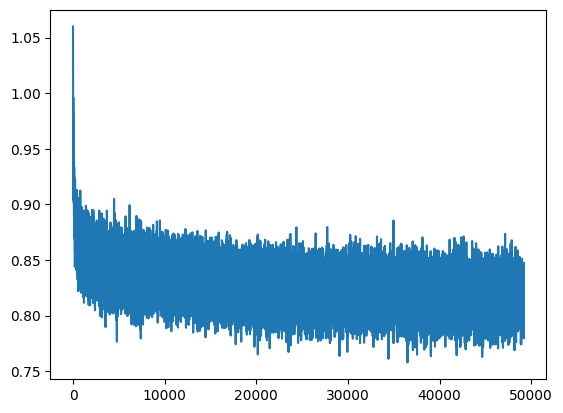

In [36]:
plt.plot(mlm_lossi)

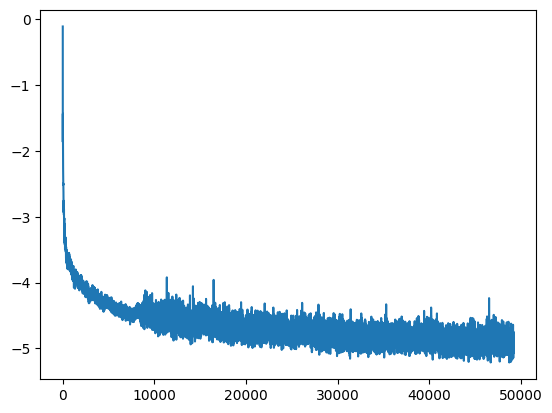

In [37]:
plt.plot(nsp_lossi)

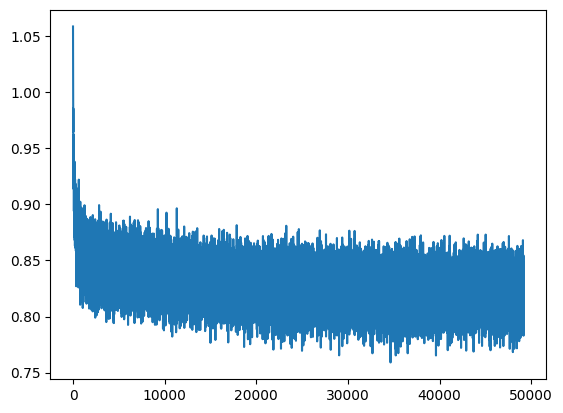

In [38]:
plt.plot(mlm_lossi_dev)

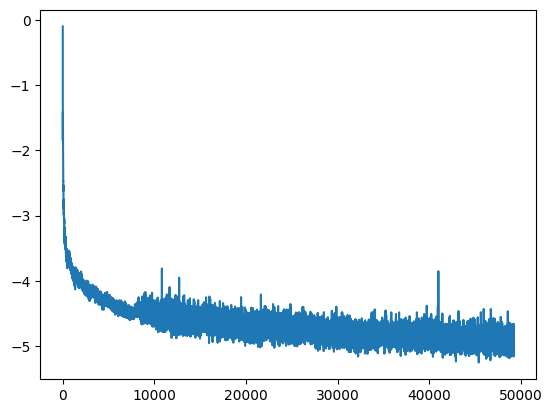

In [39]:
plt.plot(nsp_lossi_dev)

In [40]:
torch.cuda.empty_cache()
